### NLP Detect SPAM or HAM emails from message.


In [228]:
!pip install -q wordcloud
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from sklearn.metrics import accuracy_score



from nltk.sentiment.vader import SentimentIntensityAnalyzer
import wordcloud
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 
nltk.download('omw-1.4')

import io
import unicodedata
import re
import string


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gracechongzuting/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/gracechongzuting/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gracechongzuting/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/gracechongzuting/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/gracechongzuting/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [229]:
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

ps = PorterStemmer()
wordnet=WordNetLemmatizer()


In [230]:
spam_hamdf=pd.read_csv('/Users/gracechongzuting/Desktop/Jupyter Institute Data/WEEK 14/SMSSpamCollection.txt', sep='\t',names=["label", "message"])

In [231]:
spam_hamdf.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [232]:
spam_hamdf.isnull().sum()

label      0
message    0
dtype: int64

#### Now, we want to understand accuracy of baseline model.

In [233]:
X = spam_hamdf['message']
y = spam_hamdf['label']

# Split data into training and testing sets.
X_train,X_test,y_train,y_test = train_test_split(X,
                                                y,
                                                random_state = 42,
                                                stratify = y)

In [234]:
 
y.value_counts(normalize = True)

ham     0.865937
spam    0.134063
Name: label, dtype: float64

In [235]:
spam_hamdf['message']

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                 Will ü b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: message, Length: 5572, dtype: object

In [236]:
sh = spam_hamdf['message']
len(sh)

5572

In [237]:
#sh = nltk.sent_tokenize(sh)

In [238]:
sh_corpus = []
for i in range(len(sh)):
    review = re.sub('[^a-zA-Z]', ' ', sh[i]) #step 1
    review = review.lower() #step 1
    review = review.split() 
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    sh_corpus.append(review)

In [239]:
sh_corpus[1]

'ok lar joke wif u oni'

### NLP: Count Vectorizer - convert words to numerics

In [240]:
# Creating the Bag of Words model
from sklearn.feature_extraction.text import CountVectorizer
sh_corpus_cv = CountVectorizer(max_features = 1500)
X = sh_corpus_cv.fit_transform(sh_corpus).toarray()
X.shape

(5572, 1500)

In [241]:
sh_corpus_cv.get_feature_names_out()

array(['aathi', 'abiola', 'abl', ..., 'yun', 'yup', 'zed'], dtype=object)

In [242]:
sh_corpus_df = pd.DataFrame(data = X,  
                        columns = sh_corpus_cv.get_feature_names_out())
sh_corpus_df.head()
  

,aathi,abiola,abl,abt,ac,acc,accept,access,account,across,...,yet,yiju,ym,yo,yoga,yogasana,yr,yun,yup,zed
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### TFIDF Vectorizer 
- Term frequency-inverse document frequency is a text vectorizer that transforms the text into a usable vector. 
##### Term Frequency (TF) and Document Frequency (DF):

- TF : number of occurrences of a specific term in a document. Indicates how important a specific term in a document. TF has this special feature which is not present in Count Vectorizer (CV). Represents every text from the data as a matrix whose ROWS are number of documents and COLUMNS number of distinct terms throughout all documents.
- TF = No of words present in sentence/ no of words in sentence

- DF: number of documents containing a specific term. Indicates how common term is.
##### Inverse document Frequency (IDF):
- IDF: Weight of a term, aims to reduce weight of a term if term’s occurrences are scattered throughout all the documents.


- IDF = log(No. Of sentence/ No. of sentence the word contain)


In [243]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(sh, spam_hamdf['label'], test_size = 0.3, random_state = 42)
# training the vectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
sh_corpus_tfidf= TfidfVectorizer()
X_train = sh_corpus_tfidf.fit_transform(X_train)

In [244]:
X_train.shape

(3900, 7263)

In [ ]:
from sklearn import svm
svm = svm.SVC(C=1000)
svm.fit(X_train, y_train)

SVC(C=1000)

In [ ]:
from sklearn.metrics import confusion_matrix
X_test = sh_corpus_tfidf.transform(X_test)
y_pred = svm.predict(X_test)
svm_cm = confusion_matrix(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))

[[1448    0]
 [  16  208]]


In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()


/Users/gracechongzuting/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


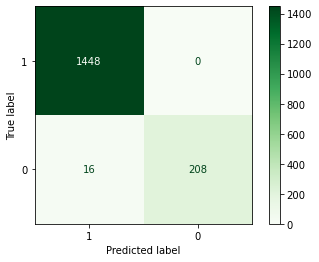

In [ ]:
from sklearn.metrics._plot.confusion_matrix import plot_confusion_matrix

plot_confusion_matrix(svm,X_test,y_test,cmap='Greens',
                      values_format = 'd', display_labels=['1','0'])

In [ ]:
cm_df = pd.DataFrame(svm_cm, columns = ['Predicted Positive (HAM)', 'Predicted Negative (SPAM)'], index =['True Positive (HAM)','True Negative (SPAM)'])
cm_df

,Predicted Positive (HAM),Predicted Negative (SPAM)
True Positive (HAM),1448,0
True Negative (SPAM),16,208


In [ ]:
from sklearn.metrics import accuracy_score,plot_roc_curve

print(f'the accuracy_score is {accuracy_score(y_test, y_pred)}')


the accuracy_score is 0.9904306220095693


/Users/gracechongzuting/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Text(0, 0.5, 'True Positive Rate = Sensitivity')

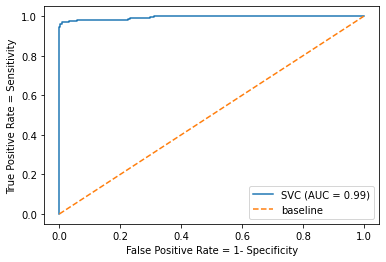

In [ ]:
plot_roc_curve(svm,X_test,y_test)
plt.plot ([0,1],[0,1],
          label = 'baseline', linestyle='--' )
plt.legend()
plt.xlabel('False Positive Rate = 1- Specificity')
plt.ylabel('True Positive Rate = Sensitivity')